# References

Lopes, Marta B., Vinga, Susana Tracking intratumoral heterogeneity in glioblastoma via regularized classification of single-cell RNA-Seq data. 2020
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3390-4

Darmanis, S., Sloan, SA., Croote, D., Mignardi, M., Chernikova, S., Samghababi, P., Zhang, Y., Neff, N., Kowarsky, M., Caneda, C., Li, Gordon., Chang, S., Connolly, I.D., Li, Y., Barres, B., Gephart, M.H., Quake, S.R. Single-Cell RNAseq analysis of infiltrating neoplastic cells at the migrating front of human glioblastoma. 2017

## Data Source

http://gbmseq.org

## R Markdown Documents Referenced by Paper

http://web.tecnico.ulisboa.pt/susanavinga/GBM/

# Environment Setup

## Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.tree        import DecisionTreeClassifier

from sklearn.metrics	 import	accuracy_score
from sklearn.metrics	 import	classification_report
from sklearn.metrics	 import	cohen_kappa_score
from sklearn.metrics	 import	confusion_matrix
from sklearn.metrics	 import	ConfusionMatrixDisplay
from sklearn.metrics	 import	mean_squared_error as MSE
from sklearn.metrics	 import	plot_confusion_matrix
from sklearn.metrics	 import	r2_score
from sklearn.metrics	 import	roc_auc_score
from sklearn.metrics	 import	roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from dtreeviz.trees import *
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

#from statsmodels.formula.api import ols
#from statsmodels.api import qqplot

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from IPython.display import display_html 

from random import sample

from scipy.stats import pearsonr
%matplotlib inline

## Functions

In [2]:
def run_mods(name,X_train,y_train,X_test,y_test,classifiers):
    result=pd.DataFrame(columns=["Case","Algorithm","Accuracy","Cohen_Kappa","ROC_AUC_Score"])
    result.Algorithm=["KNN","Decision Tree","Logistic Regression"]
    result.Case=name
    for i,c in enumerate(classifiers):
        c.fit(X_train,y_train)
        y_pred=c.predict(X_test)
        y_pred_proba=c.predict_proba(X_test)
        result.Accuracy[i]=round(accuracy_score(y_test,y_pred),3)
        result.Cohen_Kappa[i]=round(cohen_kappa_score(y_test,y_pred),3)
        result.ROC_AUC_Score[i]=round(roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted'),3)     
    global result_table
    result_table=result_table.append(result)
    
def roc_plot(X_test,y_test,classifier,title):
    y_pred_proba=classifier.predict_proba(X_test)

    fpr = {}
    tpr = {}
    thresh ={}

    CLASSES=y_test.unique()
    CLASSES=CLASSES.tolist()
    n_class = len(CLASSES)

    le = LabelEncoder()
    y_test_encoded=le.fit_transform(y_test)


    for i in range(n_class):    
        fpr[i], tpr[i], _ = roc_curve(y_test_encoded, y_pred_proba[:,i], pos_label=i)

    code=pd.DataFrame()
    code['y_original']=y_test
    code['y_coded']=y_test_encoded
    code=code.groupby('y_original').mean()
    CLASSES=list(code.index)
    
    # plotting
    color=iter(plt.cm.rainbow(np.linspace(0,1,n_class)))

    for i in range(n_class):       
        ax.plot(fpr[i], tpr[i], linestyle='--',c=next(color),label=CLASSES[i])
    ax.title.set_text(title)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive rate')
    ax.legend(loc='best')
    
def CR_plot(X_test,y_test,classifier,ax,ct):
        
    cr=classification_report(y_test,classifier.predict(X_test))
    cr=str.split(cr)
    headings=cr[0:4]
    cr=cr[4:4+5*len(y.unique())]
    
    matrix=np.array(cr).reshape(len(y.unique()),5)
    
    df=pd.DataFrame(matrix[:,1:], index=matrix[:,0], columns=headings)
    df=df.astype('float64',copy=False)
    df.support=df.support.astype(int)
      
    g=sns.heatmap(df, annot=df, vmin=0, vmax=1, ax=ax)
    for t in g.texts:
        if float(t.get_text()) > 1:     
                t.set_text(int(float(t.get_text())))
        else:
                t.set_text(round(float(t.get_text()),2))
        g.title.set_text(ct + " Classification Report")


def class_balance(X,y):
    
    classes=y.value_counts().index
    max_class=classes[0]
    classes=classes[1:]
    max_samples=y.value_counts().max()
    
    temp1=pd.concat([X,y],axis=1)
    
    resampled=pd.DataFrame(temp1[temp1[y.name]==max_class])
    
    
    for i in range(classes.size):
        temp=resample(temp1[temp1[y.name]==classes[i]],
                   replace=True,
                   n_samples=max_samples,
                   random_state=123)
        resampled=pd.concat([resampled,temp])
    
    resampled[y.name].value_counts()
    resampled = resampled.sample(frac=1).reset_index(drop=True)
    
    X_b=resampled.drop([y.name],axis=1)
    y_b=resampled[y.name]
    return(X_b,y_b)

def MAE(actual,predicted):
    return(np.mean(np.absolute(actual-predicted)))



# Collecting Data

In [3]:
df = pd.read_csv('S1_Originaldata.csv')
df.head()

class  1/2-SBSRNA4  A1BG  A1BG-AS1  A1CF  A2LD1       A2M  A2ML1  \
0  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   
1  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   
2  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  3.812781    0.0   
3  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   
4  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   

   A2MP1  A4GALT  A4GNT  AA06  AAA1  AAAS       AACS  AACSP1  AADAC  AADACL2  \
0    0.0       0    0.0     0   0.0   0.0   0.000000     0.0      0      0.0   
1    0.0       0    0.0     0   0.0   0.0   0.000000     0.0      0      0.0   
2    0.0       0    0.0     0   0.0   0.0   0.000000     0.0      0      0.0   
3    0.0       0    0.0     0   0.0   0.0   0.000000     0.0      0      0.0   
4    0.0       0    0.0     0   0.0   0.0  10.877231     0.0      0      0.0   

   AADACL3  AADACL4     AADAT  AAGAB      AAK1      AAMP  AANAT       AARS  \
0      0.0        0  0.000000    0.0  4.190018  0.000000    0.0   5.149946   
1      0.0        0  0.000000    0.0  2.204002  9.471441    0.0   8.998503   
2      0.0        0  8.796993    0.0  7.555276  0.000000    0.0   0.000000   
3      0.0        0  0.000000    0.0  5.047377  0.000000    0.0  10.366114   
4      0.0        0  0.000000    0.0  0.000000  0.000000    0.0   0.000000   

   AARS2  AARSD1     AASDH  AASDHPPT      AASS  AATF  AATK  AATK-AS1  \
0    0.0     0.0  7.522589  0.000000  0.000000   0.0   0.0         0   
1    0.0     0.0  0.000000  0.000000  6.747158   0.0   0.0         0   
2    0.0     0.0  0.000000  8.224185  0.000000   0.0   0.0         0   
3    0.0     0.0  0.000000  9.612251  0.000000   0.0   0.0         0   
4    0.0     0.0  0.000000  0.000000  6.955708   0.0   0.0         0   

       ABAT     ABCA1  ABCA10  ABCA11P  ABCA12  ABCA13   ABCA17P  ABCA2  \
0  0.000000  5.002451     0.0      0.0     0.0     0.0  5.149946    0.0   
1  0.000000  0.000000     0.0      0.0     0.0     0.0  0.000000    0.0   
2  8.474111  0.000000     0.0      0.0     0.0     0.0  0.000000    0.0   
3  0.000000  0.000000     0.0      0.0     0.0     0.0  0.000000    0.0   
4  0.000000  0.000000     0.0      0.0     0.0     0.0  0.000000    0.0   

      ABCA3  ABCA4  ABCA5  ABCA6     ABCA7     ABCA8  ABCA9  ABCB1  ABCB10  \
0  2.153964    0.0    0.0    0.0  7.627008  0.000000    0.0    0.0     0.0   
1  0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0     0.0   
2  0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0     0.0   
3  0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0     0.0   
4  0.000000    0.0    0.0    0.0  0.000000  1.677508    0.0    0.0     0.0   

   ABCB11  ABCB4  ABCB5     ABCB6     ABCB7     ABCB8  ABCB9  ABCC1  ABCC10  \
0     0.0    0.0    0.0  2.153964  9.373939  4.838141    0.0    0.0     0.0   
1     0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0     0.0   
2     0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0     0.0   
3     0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0     0.0   
4     0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0     0.0   

   ABCC11  ABCC12  ABCC13  ABCC2  ABCC3  ABCC4  ABCC5  ABCC6  ABCC6P1  \
0     0.0     0.0       0    0.0    0.0    0.0    0.0    0.0      0.0   
1     0.0     0.0       0    0.0    0.0    0.0    0.0    0.0      0.0   
2     0.0     0.0       0    0.0    0.0    0.0    0.0    0.0      0.0   
3     0.0     0.0       0    0.0    0.0    0.0    0.0    0.0      0.0   
4     0.0     0.0       0    0.0    0.0    0.0    0.0    0.0      0.0   

   ABCC6P2  ABCC8  ABCC9  ABCD1  ABCD2      ABCD3  ABCD4     ABCE1     ABCF1  \
0      0.0    0.0    0.0    0.0    0.0   0.000000    0.0  0.000000  7.007511   
1      0.0    0.0    0.0    0.0    0.0   0.000000    0.0  0.000000  0.000000   
2      0.0    0.0    0.0    0.0    0.0  10.379791    0.0  0.000000  7

In [4]:
# replacing values
df['class'].replace(['Neoplastic_Core', 'Neoplastic_Periphery'],[0, 1], inplace=True)

# Modeling

## Discrimination between neoplastic astrocytes from the periphery and tumor core

In [5]:
# split into train and test 
train, test = train_test_split(df,random_state=42, test_size = 0.3)
y_test = test['class']
y_train = train['class']
X_train = train.drop(['class'],axis=1)
X_test = test.drop(['class'],axis=1)

#### Model 1 Parameter Exploration

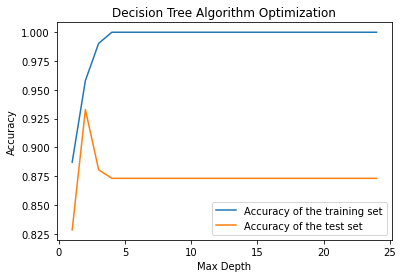

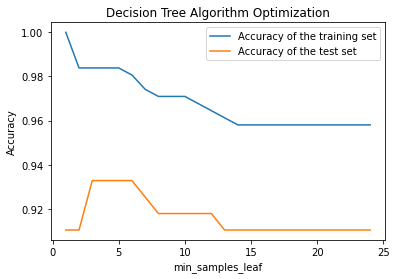

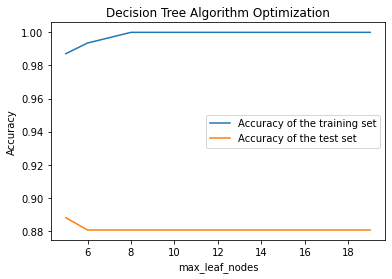

In [6]:
S1_training_accuracy_depth = []
S1_test_accuracy_depth = []

max_dep = range(1,25)

for md in max_dep:
    tree = DecisionTreeClassifier(criterion='entropy',max_depth=md,random_state=21)
    tree.fit(X_train,y_train)
    S1_training_accuracy_depth.append(tree.score(X_train, y_train))
    S1_test_accuracy_depth.append(tree.score(X_test, y_test))

plt.plot(max_dep,S1_training_accuracy_depth, label='Accuracy of the training set')
plt.plot(max_dep,S1_test_accuracy_depth, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()
plt.title('Decision Tree Algorithm Optimization')
plt.savefig('Scenario 1 Parameter Exploration Max Depth.png',dpi=300, bbox_inches = "tight")
plt.show()


max(S1_test_accuracy_depth)
max_index=S1_test_accuracy_depth.index(max(S1_test_accuracy_depth))
best_dep=max_dep[max_index]

######

S1_training_accuracy_leaf = []
S1_test_accuracy_leaf = []

max_leaf = range(1,25)

for ml in max_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=ml,max_depth=15,random_state=21)
    tree.fit(X_train,y_train)
    S1_training_accuracy_leaf.append(tree.score(X_train, y_train))
    S1_test_accuracy_leaf.append(tree.score(X_test, y_test))

plt.plot(max_dep,S1_training_accuracy_leaf, label='Accuracy of the training set')
plt.plot(max_dep,S1_test_accuracy_leaf, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('min_samples_leaf')
plt.legend()
plt.title('Decision Tree Algorithm Optimization')
plt.savefig('Scenario 1 Parameter Exploration Min Leaf Sample.png',dpi=300, bbox_inches = "tight")
plt.show()


max(S1_training_accuracy_leaf)
max_index=S1_test_accuracy_leaf.index(max(S1_test_accuracy_leaf))
best_leaf=max_leaf[max_index]

#######
S1_training_accuracy_nodes = []
S1_test_accuracy_nodes = []

max_nodes = range(5,20)

for mn in max_nodes:
    tree = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=mn,max_depth=15,random_state=21)
    tree.fit(X_train,y_train)
    S1_training_accuracy_nodes.append(tree.score(X_train, y_train))
    S1_test_accuracy_nodes.append(tree.score(X_test, y_test))

plt.plot(max_nodes,S1_training_accuracy_nodes, label='Accuracy of the training set')
plt.plot(max_nodes,S1_test_accuracy_nodes, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('max_leaf_nodes')
plt.legend()
plt.title('Decision Tree Algorithm Optimization')
plt.savefig('Scenario 1 Parameter Exploration Max Leaves.png',dpi=300, bbox_inches = "tight")
plt.show()

max(S1_test_accuracy_nodes)
max_index=S1_test_accuracy_nodes.index(max(S1_test_accuracy_nodes))
best_nodes=max_nodes[max_index]


In [7]:
print('The best Parameters for the Decision Tree algorithm were found to be:')
print('max_depth:',best_dep)
print('min_samples_leaf:',best_leaf)
print('max_leaf_nodes:',best_nodes)

The best Parameters for the Decision Tree algorithm were found to be:
max_depth: 2
min_samples_leaf: 3
max_leaf_nodes: 5


In [8]:
# Baseline Model
dt = DecisionTreeClassifier(random_state=21)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.04%


In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer

df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

row = {'model': 'DT',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
        'roc_auc': round(roc_auc,3),
        'avg_pre': round(avg_precision,3),
    }

df_result = df_result.append(row, ignore_index=True)
df_result.head()

model  tp   tn fp fn correct incorrect  accuracy  precision  recall     f1  \
0    DT  17  105  6  6     122        12      0.91      0.739   0.739  0.739   

   roc_auc  avg_pre  
0    0.843    0.591

In [10]:
# Preliminary Optimization Result
dtopt = DecisionTreeClassifier(criterion='entropy',
                            min_samples_leaf=best_leaf,
                            max_leaf_nodes=best_nodes,
                            max_depth=best_dep,
                            random_state=21)
dtopt.fit(X_train,y_train)

y_predopt = dtopt.predict(X_test) 
accuracy = accuracy_score(y_test, y_predopt) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.28%


In [11]:
df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

tn, fp, fn, tp = confusion_matrix(y_test, y_predopt).ravel()
accuracy = accuracy_score(y_test, y_predopt)
precision = precision_score(y_test, y_predopt)
recall = recall_score(y_test, y_predopt)
f1 = f1_score(y_test, y_predopt)
roc_auc = roc_auc_score(y_test, y_predopt)
avg_precision = average_precision_score(y_test, y_predopt)

row = {'model': 'DT',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
        'roc_auc': round(roc_auc,3),
        'avg_pre': round(avg_precision,3),
    }

df_result = df_result.append(row, ignore_index=True)
df_result.head()

model  tp   tn fp fn correct incorrect  accuracy  precision  recall     f1  \
0    DT  19  106  5  4     125         9     0.933      0.792   0.826  0.809   

   roc_auc  avg_pre  
0    0.891    0.684

In [12]:
print(classification_report(y_test,y_predopt))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       111
           1       0.79      0.83      0.81        23

    accuracy                           0.93       134
   macro avg       0.88      0.89      0.88       134
weighted avg       0.93      0.93      0.93       134



In [13]:
#SKlearn plot confusion matrix
print(confusion_matrix(y_test,y_predopt))

[[106   5]
 [  4  19]]
